Caricamento SVOX Night...
Caricamento SVOX Sun...
Caricamento SF-XS...
Caricamento Tokyo-XS...


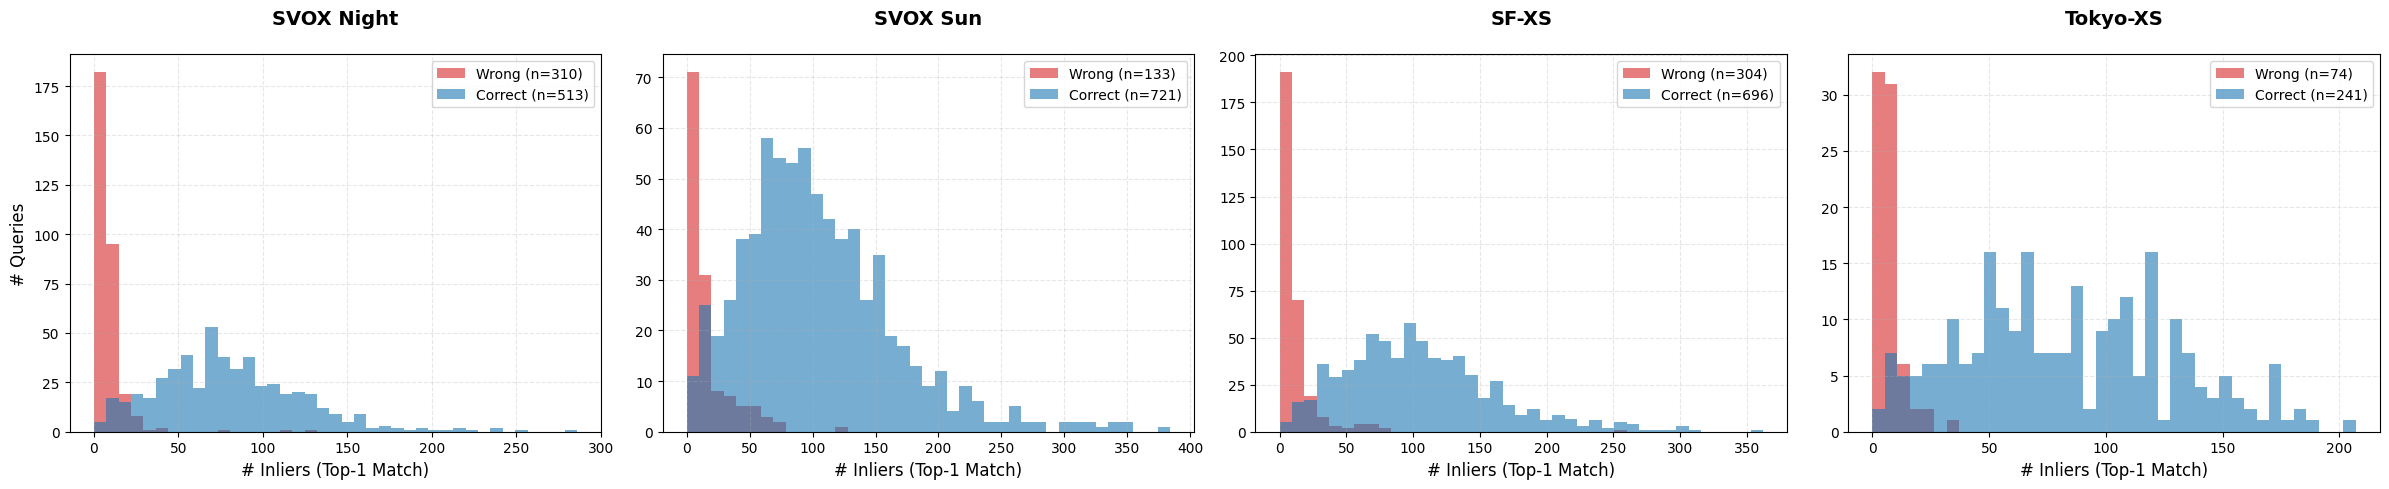

In [ ]:
import numpy as np
import torch
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt


import sys, os
sys.path.append(os.getcwd())
from util import get_list_distances_from_preds

POSITIVE_DIST_THRESHOLD = 25

#SUPPORT FUNCTION
def load_correct_and_inliers(preds_dir, inliers_dir, thr=25):
    txt_files = sorted(glob(str(Path(preds_dir) / "*.txt")), key=lambda x: int(Path(x).stem))
    

    y_correct = np.zeros(len(txt_files), dtype=np.int32)
    inliers = np.zeros(len(txt_files), dtype=np.float64)

    for i, txt in enumerate(txt_files):
        # 1. Ground Truth
        dists = get_list_distances_from_preds(txt)
        y_correct[i] = 1 if dists[0] <= thr else 0

        # 2. Inliers
        torch_file = Path(inliers_dir) / Path(txt).name.replace(".txt", ".torch")
        if torch_file.exists():
            r = torch.load(torch_file, map_location="cpu", weights_only=False)
            if len(r) > 0: inliers[i] = r[0]["num_inliers"]
        else:
            inliers[i] = 0
            
    return y_correct, inliers

# --- CONFIG DATASETS ---
datasets_config = [
    {
        "name": "SVOX Night",
        "preds": "test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds",
        "inliers": "test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds_superpoint-lg"
    },
    {
        "name": "SVOX Sun",
        "preds": "test_logs/logs_svox_sun/mixvpr_resnet50_svox_sun/preds",
        "inliers": "test_logs/logs_svox_sun/mixvpr_resnet50_svox_sun/preds_superpoint-lg"
    },
    {
        "name": "SF-XS",
        "preds": "test_logs/logs_sf_xs/mixvpr_resnet50_sf_xs/preds",
        "inliers": "test_logs/logs_sf_xs/mixvpr_resnet50_sf_xs/preds_superpoint-lg"
    },
    {
        "name": "Tokyo-XS",
        "preds": "test_logs/logs_tokyo_xs/mixvpr_resnet50_tokyo_xs/preds",
        "inliers": "test_logs/logs_tokyo_xs/mixvpr_resnet50_tokyo_xs/preds_superpoint-lg"
    }
]

# --- PLOTTING 1x4 ---
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=False) # sharey=False perché il n. di query varia molto


for i, config in enumerate(datasets_config):
    ax = axes[i]
    print(f"Loading {config['name']}...")
    
    y, inliers = load_correct_and_inliers(config['preds'], config['inliers'], thr=POSITIVE_DIST_THRESHOLD)
    
    if len(y) == 0: continue


    # Division Correct/Wrong
    correct = inliers[y == 1]
    wrong = inliers[y == 0]

    # Computes bins
    min_val = inliers.min() if len(inliers) > 0 else 0
    max_val = inliers.max() if len(inliers) > 0 else 100
    bins = np.linspace(min_val, max_val, 40)

    # histogram
    ax.hist(wrong, bins=bins, alpha=0.6, color='tab:red', label=f"Wrong (n={len(wrong)})")
    ax.hist(correct, bins=bins, alpha=0.6, color='tab:blue', label=f"Correct (n={len(correct)})")
    
    # Labels and title
    ax.set_title(f"{config['name']}\n", fontsize=14, fontweight='bold')
    ax.set_xlabel("# Inliers (Top-1 Match)", fontsize=12)
    if i == 0: ax.set_ylabel("# Queries", fontsize=12)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

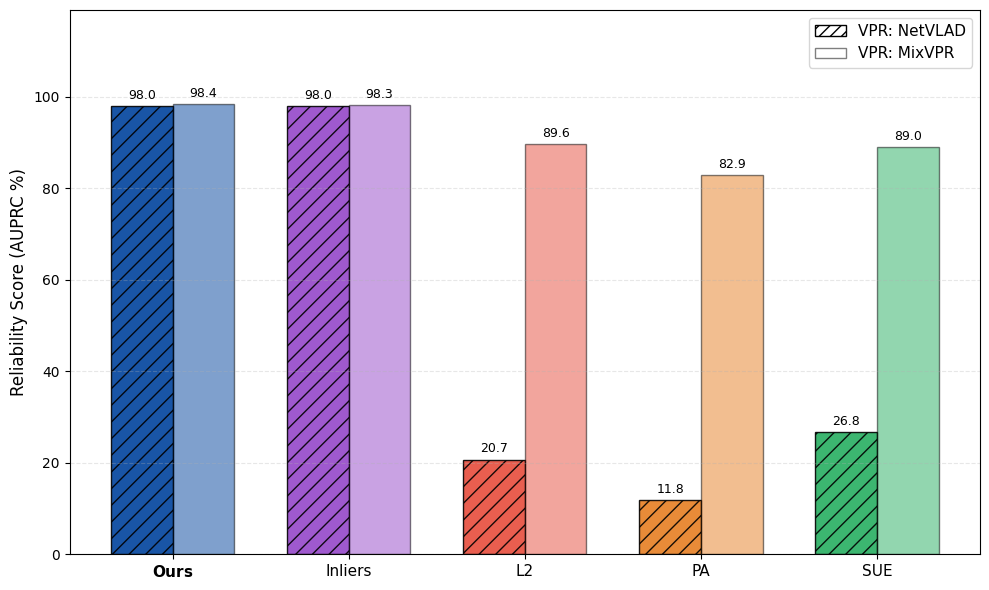

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def plot_netvlad_vs_mixvpr_night():
    # --- DATA (SVOX Night) ---
    # NetVLAD + LightGlue
    netvlad_scores = [98.0, 98.0, 20.7, 11.8, 26.8] # [Ours, Inliers, L2, PA, SUE]
    
    # MixVPR + LightGlue
    mixvpr_scores = [98.4, 98.3, 89.6, 82.9, 89.0] # [Ours, Inliers, L2, PA, SUE]
    
    methods = ['Ours', 'Inliers', 'L2', 'PA', 'SUE']
    
   
    colors = ["#00429d", "#9547c9", '#e74c3c', '#e67e22', '#27ae60'] 

    # --- PLOT SETUP ---
    x = np.arange(len(methods))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))

    # bars NetVLAD (Ours)
    rects1 = ax.bar(x - width/2, netvlad_scores, width, color=colors, alpha=0.9, hatch='//', edgecolor='black', label='Method: NetVLAD')
    
    # Bars MIXVPR 
    rects2 = ax.bar(x + width/2, mixvpr_scores, width, color=colors, alpha=0.5, edgecolor='black', label='Method: MixVPR')

    # Legend 
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', hatch='///', label='VPR: NetVLAD'),
        Patch(facecolor='white', edgecolor='black', alpha=0.5, label='VPR: MixVPR')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

    # Labels and aesthetics
    ax.set_ylabel('Reliability Score (AUPRC %)', fontsize=12)
    ax.set_xticks(x)
    labels = [r"$\bf{Ours}$" if m == "Ours" else m for m in methods]
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylim(0, 119) # Spazio per le frecce
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Values 
    ax.bar_label(rects1, padding=3, fmt='%.1f', fontsize=9)
    ax.bar_label(rects2, padding=3, fmt='%.1f', fontsize=9)

    plt.tight_layout()
    plt.savefig("comparison_netvlad_mixvpr.svg", format='svg', bbox_inches='tight')
    plt.show()

plot_netvlad_vs_mixvpr_night()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_overlay_models(X_only, prob_only, X_full, prob_full, y_true):
    inliers_only = np.asarray(X_only).ravel()
    inliers_full = np.asarray(X_full).ravel()
    prob_only = np.asarray(prob_only).ravel()
    prob_full = np.asarray(prob_full).ravel()
    y_true = np.asarray(y_true).ravel()

    plt.figure(figsize=(10, 7))

    mask_correct = (y_true == 1)
    mask_wrong = (y_true == 0)

    # Ours
    plt.scatter(inliers_full[mask_correct], prob_full[mask_correct],
                color="#3b2ecc", alpha=0.6, s=15, label='Ours - Correct')
    plt.scatter(inliers_full[mask_wrong], prob_full[mask_wrong],
                color="#F90404", alpha=0.2, s=15, label='Ours - Wrong')

    # Baseline
    plt.scatter(inliers_only[mask_correct], prob_only[mask_correct],
                color="#ccdde4", alpha=0.6, s=15, label='Baseline - Correct')
    plt.scatter(inliers_only[mask_wrong], prob_only[mask_wrong],
                color="#F90404", alpha=0.2, s=15, label='Baseline - Wrong')

    plt.xlabel("Number of Inliers", fontsize=12)
    plt.ylabel("Confidence Score", fontsize=12)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.2)
    plt.show()




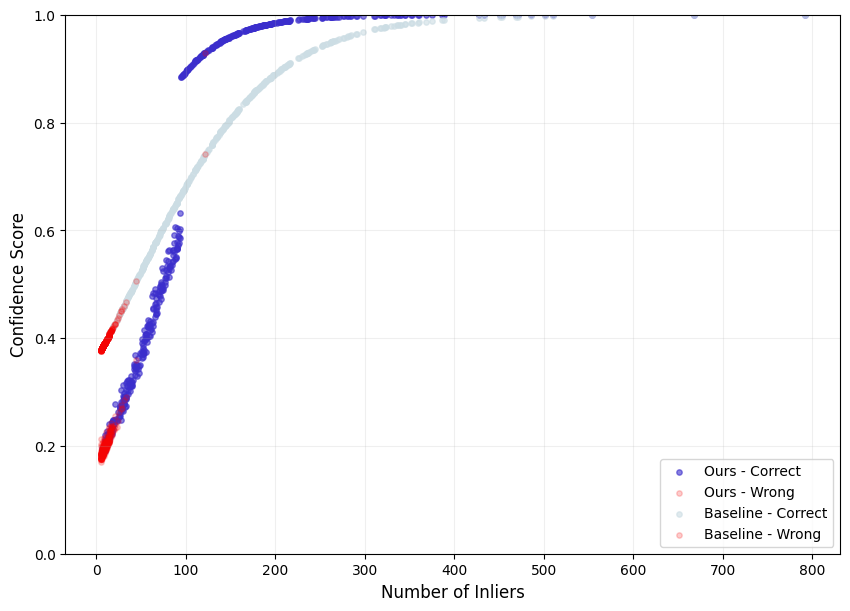

In [77]:

plot_overlay_models(np.load("curves_inliers/mixvpr/svox_sun_svox_night/Inliers.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_Inliers.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Inliers.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_Inliers_L2_gated.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Y_test.npy"))

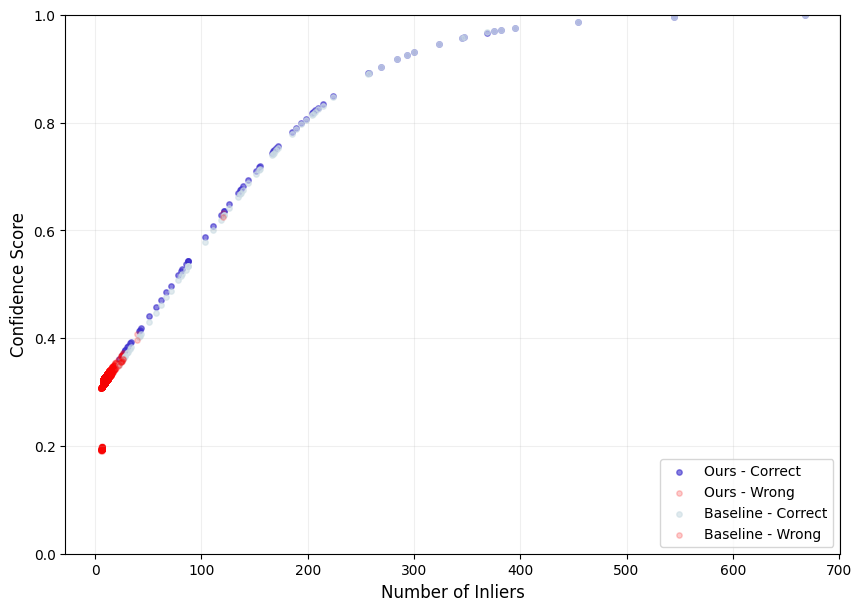

In [69]:
plot_overlay_models(np.load("curves_inliers/netvlad/svox_sun_svox_night/Inliers.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_Inliers.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Inliers.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_Inliers_L2_gated.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Y_test.npy"))

In [82]:
from sklearn.metrics import precision_recall_curve, auc
def plot_prc(y_true, prob_inliers, prob_inliers_gatedl2,probs_l2=None,probs_pa=None):


    precision_inliers, recall_inliers, _ = precision_recall_curve(y_true, prob_inliers)
    precision_inliers_gatedl2, recall_inliers_gatedl2, _ = precision_recall_curve(y_true, prob_inliers_gatedl2)
    auprc_inliers = auc(recall_inliers, precision_inliers)
    auprc_full = auc(recall_inliers_gatedl2, precision_inliers_gatedl2)

    plt.figure(figsize=(8, 6))
    rand_base = np.mean(y_true)
    plt.axhline(rand_base, linestyle='--', linewidth=1,label=f'Random (y_true) - Precision={rand_base:.3f}', color='gray')
    plt.plot(recall_inliers, precision_inliers, label=f'Baseline (Inliers Only) - AUPRC: {auprc_inliers:.3f}', color='#ccdde4')
    plt.plot(recall_inliers_gatedl2, precision_inliers_gatedl2, label=f'Ours (Inliers + Gated L2) - AUPRC: {auprc_full:.3f}', color='#3b2ecc')
    if probs_l2 is not None and y_true is not None:
        precision_l2, recall_l2, _ = precision_recall_curve(y_true, probs_l2)
        auprc_l2 = auc(recall_l2, precision_l2)
        plt.plot(recall_l2, precision_l2, label=f'Baseline (L2 Only) - AUPRC: {auprc_l2:.3f}', color='#e74c3c')
    if probs_pa is not None and y_true is not None:
        precision_pa, recall_pa, _ = precision_recall_curve(y_true, probs_pa)
        auprc_pa = auc(recall_pa, precision_pa)
        plt.plot(recall_pa, precision_pa, label=f'Baseline (PA-Score) - AUPRC: {auprc_pa:.3f}', color='#e67e22')    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.show()

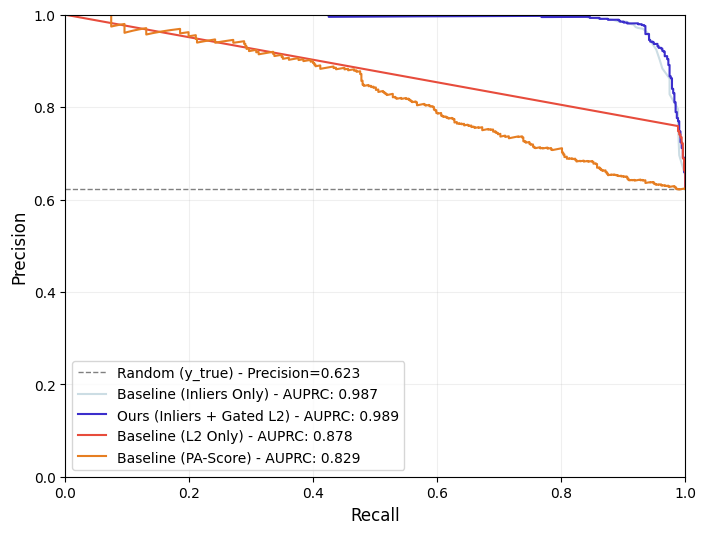

In [83]:
plot_prc(np.load("curves_inliers/mixvpr/svox_sun_svox_night/Y_test.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_Inliers.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_Inliers_L2_gated.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_L2.npy"),  np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_pa.npy"))

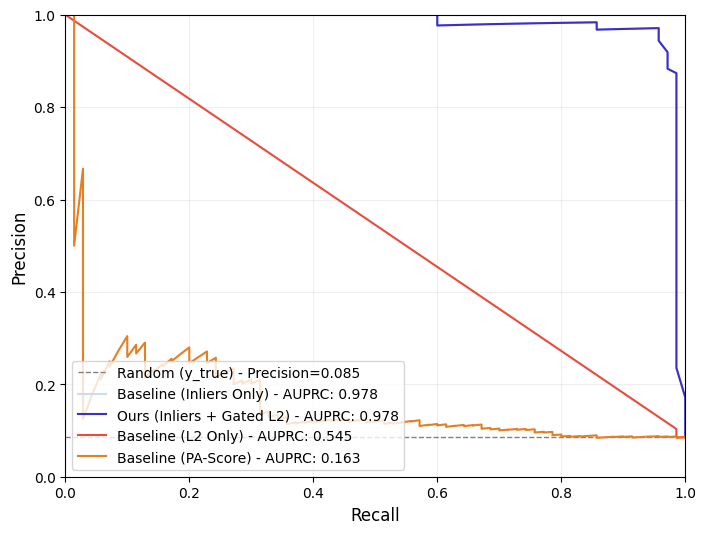

In [84]:
plot_prc(np.load("curves_inliers/netvlad/svox_sun_svox_night/Y_test.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_Inliers.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_Inliers_L2_gated.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_L2.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_pa.npy"))

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def _ausc_curve_from_uncertainty(uncertainty_scores, labels_correct):
    u = np.asarray(uncertainty_scores).ravel()
    y = np.asarray(labels_correct).ravel()
    assert len(u) == len(y), "uncertainty_scores and labels must have same length"

    idxs = np.argsort(u)[::-1]          # most uncertain first
    sorted_labels = y[idxs]
    errors = 1 - sorted_labels          # 1 if wrong

    n = len(errors)
    remaining_errors_sum = np.cumsum(errors[::-1])[::-1]
    remaining_count = np.arange(1, n + 1)[::-1]
    error_curve = remaining_errors_sum / remaining_count

    rejection_rates = np.linspace(0, 1, n)

    
    x = rejection_rates[:-1]
    y_curve = error_curve[:-1]
    ausc_val = auc(x, y_curve)
    return x, y_curve, ausc_val


def plot_ausc(y_true, prob_inliers, prob_inliers_gatedl2, probs_l2=None, probs_pa=None):
    y_true = np.asarray(y_true).ravel()

    #confidence -> uncertainty
    u_inliers = 1.0 - np.asarray(prob_inliers).ravel()
    u_gated = 1.0 - np.asarray(prob_inliers_gatedl2).ravel()

    plt.figure(figsize=(8, 6))

    # Random curve
    rand_err = np.mean(1 - y_true)  # frazione wrong
    plt.axhline(rand_err, linestyle='--', linewidth=1,
                label=f'Random rejection - err={rand_err:.3f}', color='gray')

    # Baseline inliers
    x_b, y_b, ausc_b = _ausc_curve_from_uncertainty(u_inliers, y_true)
    plt.step(x_b, y_b, where="post",
             label=f'Baseline (Inliers Only) - AUSC: {ausc_b:.3f}', color='#ccdde4')

    # Ours gated
    x_o, y_o, ausc_o = _ausc_curve_from_uncertainty(u_gated, y_true)
    plt.step(x_o, y_o, where="post",
             label=f'Ours (Inliers + Gated L2) - AUSC: {ausc_o:.3f}', color='#3b2ecc')

    # L2 only (optional)
    if probs_l2 is not None:
        u_l2 = 1.0 - np.asarray(probs_l2).ravel()
        x_l2, y_l2_curve, ausc_l2 = _ausc_curve_from_uncertainty(u_l2, y_true)
        plt.step(x_l2, y_l2_curve, where="post",
                 label=f'Baseline (L2 Only) - AUSC: {ausc_l2:.3f}', color='#e74c3c')

    # PA score (optional)
    if probs_pa is not None:
        u_pa = 1.0 - np.asarray(probs_pa).ravel()
        x_pa, y_pa_curve, ausc_pa = _ausc_curve_from_uncertainty(u_pa, y_true)
        plt.step(x_pa, y_pa_curve, where="post",
                 label=f'Baseline (PA-Score) - AUSC: {ausc_pa:.3f}', color='#e67e22')

    plt.xlabel('Rejection Rate', fontsize=12)
    plt.ylabel('Error rate on remaining samples', fontsize=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.show()


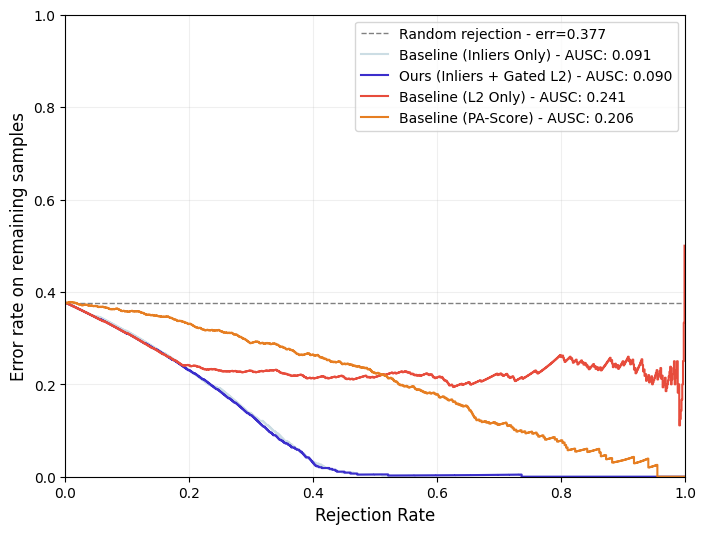

In [89]:
plot_ausc(np.load("curves_inliers/mixvpr/svox_sun_svox_night/Y_test.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_Inliers.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_Inliers_L2_gated.npy"), np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_L2.npy"),  np.load("curves_inliers/mixvpr/svox_sun_svox_night/Probs_pa.npy"))

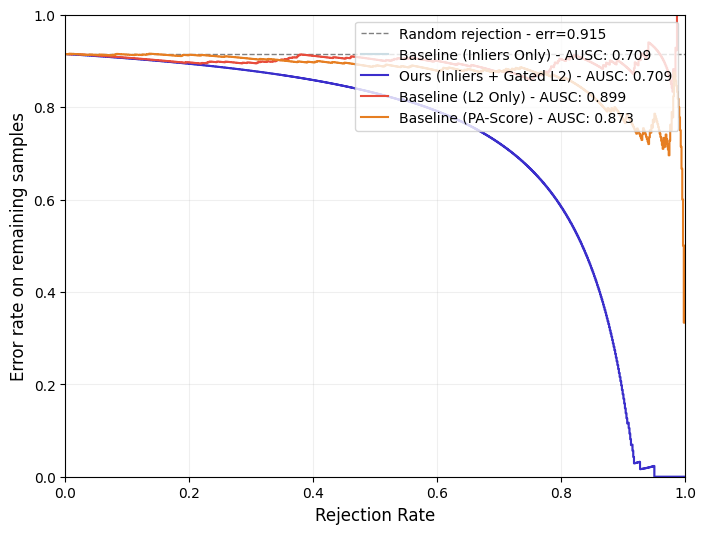

In [90]:
plot_ausc(np.load("curves_inliers/netvlad/svox_sun_svox_night/Y_test.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_Inliers.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_Inliers_L2_gated.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_L2.npy"), np.load("curves_inliers/netvlad/svox_sun_svox_night/Probs_pa.npy"))